# RNN
---

전통적인 Neural Network에서는 순서라는 것을 기억하지 못한다. 그러나 우리가 알고 싶어하는 것들은 순서가 있는 경우가 많다. 예를 들어, 주가의 패턴을 분석하고 싶다면, 과거의 주가를 고려해서 분석하고자 할 것이다. RNN(순환 신경망)은 이 문제를 해결해준다.b

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## RNN 특징

### Sequence
일반적인 Neural Network(CNN포함)에서는 고정된 size의 vector를 Input으로 넣고, 고정된 size의 output을 도출한다. 그러나 RNN에서는 다양한 형태의 Input과 Output 사이즈를 도출해낼 수 있을 뿐만 아니라, 벡터의 순서를 Input으로 넣을 수 있다는것이 가장 큰 장점이다.

![](./figs/RNN0.png)

좌측부터:
* one-to-one(121): 일반적인 Neural Network
* one-to-many(12N): Sequence output, e.g.) Image captioning: 이미지를 한장 넣으면 문장을 생성
* many-to-one(N21): Sequence input, e.g.) Sentiment analysis: 감성분석
* many-to-many(N2N): Sequence input & output, e.g.) Machine Translation: 기계 번역 
* many-to-many(N2N): Synced sqeuence input & output, e.g.) Video classification: 매 프레임 마다 분류

### RNN Computation

![](./figs/RNN1.png)

### Forward

hello world 찍어보기

$$\begin{aligned} 
h_t &= tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h) \\
y_t &= W_{hy} h_{t} + b_y
\end{aligned}$$

Size:
$$\begin{aligned}
x_t &: V, \\
h_t &: N, \\
y_t &: M, \\
W_{xh} &: V \times N \\
W_{hh} &: N \times N ,\quad where \ t=0 \ init \ as \ 0s\\
W_{hy} &: M \times N \\
b_h &: N, \\
b_y &: M, 
\end{aligned}$$

In [1]:
from common.utils_nn import *
from common.layers import *
from common.optimizer import *
from collections import OrderedDict, defaultdict

In [2]:
class Linear(object):
    def __init__(self, W, b=None, bias=True):
        self.bias = bias
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        if self.bias:
            out = np.dot(self.x, self.W) + self.b
        else:
            out = np.dot(self.x, self.W)
            
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        if self.bias:
            self.db = np.sum(self.b, axis=0)
        else:
            self.db = None
            
        return dx

In [3]:
class Single_layer_RNN(object):
    def __init__(self, input_size, hidden_size, output_size, bptt_truncate):
        self.input_size = input_size # V
        self.hidden_size = hidden_size # N
        self.output_size = output_size # M
        self.bptt_truncate = bptt_truncate
        
        self.params = {}
        self.params_init()
        
        self.layers = None
        self.last_layers = None
        self.T = None
        self.h0 = None
        
    def params_init(self):
        scale_xh = np.sqrt(1.0 / self.input_size)
        scale_hh = np.sqrt(1.0 / self.hidden_size)
        self.params['W_xh'] = np.random.randn(self.input_size, self.hidden_size) * scale_xh
        self.params['W_hh'] = np.random.randn(self.hidden_size, self.hidden_size) * scale_hh
        self.params['W_hy'] = np.random.randn(self.hidden_size, self.output_size) * scale_hh
        self.params['b_h'] = np.zeros((1, self.hidden_size))
        self.params['b_y'] = np.zeros((1, self.output_size))
    
    def _hidden_init(self):
        self.h0 = np.zeros((1, self.hidden_size))
        return self.h0
    
    def _layers_init(self):
        self.layers = defaultdict(OrderedDict)
        for i in np.arange(self.T):
            self.layers['Affine_xh'][i] = Linear(self.params['W_xh'], bias=False)
            self.layers['Affine_hh'][i] = Linear(self.params['W_hh'], self.params['b_h'])
            self.layers['Tanh'][i] = Tanh()
            self.layers['Affine_hy'][i] = Linear(self.params['W_hy'], self.params['b_y'])
    
    def _last_layers_init(self):
        self.last_layers = {}
        for i in np.arange(self.T):
            self.last_layers[i] = SoftmaxWithLoss()
    
    def forward(self, x):
        self.T = len(x)
        if self.layers is None:
            self._layers_init()
        
        hs = {}
        hs[-1] = self._hidden_init()
        os = {}
        
        for i in np.arange(self.T):
            a = self.layers['Affine_hh'][i].forward(hs[i-1]) + \
                self.layers['Affine_xh'][i].forward(x[i:i+1, :])
            hs[i] = self.layers['Tanh'][i].forward(a)
            os[i] = self.layers['Affine_hy'][i].forward(hs[i])
            
        return os, hs

    def predict(self, x):
        os, hs = self.forward(x)
        result = []
        for i in np.arange(self.T):
            max_idx = np.argmax(os[i])
            result.append(max_idx)
        return np.array(result)
            
    def loss(self, x, t):
        total_loss = 0
        os, hs = self.forward(x)
        if self.last_layers is None:
            self._last_layers_init()
        
        for i in range(self.T):
            loss = self.last_layers[i].forward(os[i], t[i].reshape(1, -1))
            total_loss += loss
        
        return total_loss / len(t)

    def backward(self):
        # BPTT
        self._params_summation_init()
        dht = np.zeros_like(self.h0)
        
        for t in np.arange(self.T)[::-1]:
            dout = self.last_layers[t].backward()
            dht_raw = self.layers['Affine_hy'][t].backward(dout)
            dat = self.layers['Tanh'][t].backward(dht_raw) + dht 
            dht = self.layers['Affine_hh'][t].backward(dat)
            dx = self.layers['Affine_xh'][t].backward(dat) # dx
            self._params_summation(t)
#         self._params_summation(key=False)

    def _params_summation_init(self):
        self.params_summ = {}
        self.summ_count = 0
        self.params_summ['W_xh'] = np.zeros_like(self.params['W_xh'])
        self.params_summ['W_hh'] = np.zeros_like(self.params['W_hh'])
        self.params_summ['W_hy'] = np.zeros_like(self.params['W_hy'])
        self.params_summ['b_h'] = np.zeros_like(self.params['b_h'])
        self.params_summ['b_y'] = np.zeros_like(self.params['b_y'])
    
    def _params_summation(self, step=None, key=True):
        if key:
            self.summ_count += 1
            self.params_summ['W_xh'] += self.layers['Affine_xh'][step].dW
            self.params_summ['W_hh'] += self.layers['Affine_hh'][step].dW
            self.params_summ['W_hy'] += self.layers['Affine_hy'][step].dW
            self.params_summ['b_h'] += self.layers['Affine_hh'][step].db
            self.params_summ['b_y'] += self.layers['Affine_hy'][step].db
        else:
            for k, v in self.params_summ.items():
                self.params_summ[k] = v / self.summ_count

    def backward_truncate(self):
        # TBPTT
        self._params_summation_init()
        dht = np.zeros_like(self.h0)
        
        for t in np.arange(self.T)[::-1]:
            dout = self.last_layers[t].backward()
            dht_raw = self.layers['Affine_hy'][t].backward(dout)
            self.params_summ['W_hy'] += self.layers['Affine_hy'][t].dW
            self.params_summ['b_y'] += self.layers['Affine_hy'][t].db
            
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                dat = self.layers['Tanh'][bptt_step].backward(dht_raw) + dht 
                dht = self.layers['Affine_hh'][bptt_step].backward(dat)
                dx = self.layers['Affine_xh'][bptt_step].backward(dat) # dx
                self.params_summ['W_xh'] += self.layers['Affine_xh'][bptt_step].dW
                self.params_summ['W_hh'] += self.layers['Affine_hh'][bptt_step].dW
                self.params_summ['b_h'] += self.layers['Affine_hh'][bptt_step].db

    def gradient_check(self, x, t, delta=0.001, th_error=0.1, num_check=3):
        ks = list(self.params_summ.keys())
        f = lambda w: self.loss(x, t)
        for name in ks:
            s0 = self.params[name].shape
            s1 = self.params_summ[name].shape
            assert s0 == s1, \
                "[Error] dimensions don't match: ({}) params-{} grads-{}".format(name, s0, s1)
            for i in np.arange(num_check):
                num_grads = numerical_gradient(f, self.params[name])
                back_grads = self.params_summ[name]
                rel_error = np.abs(back_grads - num_grads) / (np.abs(back_grads) + np.abs(num_grads))
                mask = rel_error > th_error
            print(name, mask.sum())

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

In [5]:
x = 'hello world! nice to meet you'
data = list(x)

encoder = chr_coding()
encoder.fit(data)
one_hot_data = encoder.encode(data)

In [6]:
np.random.seed(1234)
num_epochs = 4500
input_size = one_hot_data.shape[1]
hidden_size = 20
output_size = one_hot_data.shape[1]
seq_len = one_hot_data.shape[0] - 1

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

In [8]:
rnn = Single_layer_RNN(input_size, hidden_size, output_size, 2)
optim = Adam()

In [9]:
total_loss_list = []

for epoch in range(num_epochs):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward
    rnn.backward()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    if epoch % 100 == 0:
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))
    elif epoch == (num_epochs-1):
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))

    total_loss_list.append(total_loss)    

#0, Loss: 2.822245765980379, test: "homn hccoeyi wtnuue ocmouytwn"
#100, Loss: 2.2130160498472344, test: "hrmoo moe ioyuior ioruio moo "
#200, Loss: 1.9846814569906672, test: "hrlyo lco dor dor do lio lyo "
#300, Loss: 1.927565437569902, test: "h l!o lco l!o doewyo lyo doo "
#400, Loss: 1.8204272425351995, test: "h l!o loo l!onioe to l!onlyo "
#500, Loss: 2.054850890060293, test: "h loo loo loonloonloonloo loo"
#600, Loss: 1.9775739417233993, test: "h lo  lo  lo nlo nlo nlo  lo "
#700, Loss: 1.9538247955099346, test: "h lo  lo  lo nlo nlo nlo  lo "
#800, Loss: 1.9356489160366093, test: "h lo  lo  lo nlo nlo nlo  lo "
#900, Loss: 1.9191112461769932, test: "h lo  lo  lo nlo nlo nio  lo "
#1000, Loss: 1.8917680271605124, test: "h lo  lo  lo nio nio nio  lo "
#1100, Loss: 1.8482265580620576, test: "h lo  lo  lo  lo  do  io  lo "
#1200, Loss: 1.7944946108016715, test: "h lo  lo  lo nio nio mio  lo "
#1300, Loss: 1.7622684606978358, test: "helo  lo  lo nio nio mio  lo "
#1400, Loss: 1.790515

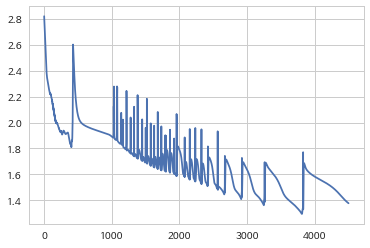

In [10]:
plt.plot(total_loss_list)

In [11]:
rnn = Single_layer_RNN(input_size, hidden_size, output_size, 4)
optim = Adam()

In [12]:
total_loss_list = []

for epoch in range(num_epochs):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward
    rnn.backward_truncate()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    if epoch % 100 == 0:
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))
    elif epoch == (num_epochs-1):
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))

    total_loss_list.append(total_loss)

#0, Loss: 2.849657981617288, test: "hruturrtmyntuut yetmdututmutd"
#100, Loss: 2.2707717379138685, test: "h oto  etlot  t eetoe tet tot"
#200, Loss: 1.916474285667776, test: "h lto mtrlot niceetoe t e yo "
#300, Loss: 1.6382992753025376, test: "helto wtrldt nicemtoe t e you"
#400, Loss: 1.3925130363765292, test: "helto wtrld! nicemto me t you"
#500, Loss: 1.1884655269923872, test: "heloo wtrld! nicemto me t you"
#600, Loss: 1.0291055337256665, test: "heloo wtrld! nicemto me t you"
#700, Loss: 0.9019874331660666, test: "heloo wtrld! nice to meot you"
#800, Loss: 0.7875043588659938, test: "heloo wirld! nice to meet you"
#900, Loss: 0.6791683432954582, test: "heloo world! nice to meet you"
#1000, Loss: 0.6071147996834968, test: "hello world! nice to meet you"
#1100, Loss: 0.5772032259923012, test: "hello world! nice to meet you"
#1200, Loss: 0.5175250189365059, test: "hello world! nice to meet you"
#1300, Loss: 0.4628002971768628, test: "hello world! nice to meet you"
#1400, Loss: 0.41837

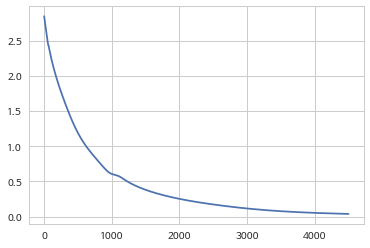

In [13]:
plt.plot(total_loss_list)